# QuantumSim - Noise
Author: Nico Kuijpers<br>
Date: December 10, 2025

In this Jupyter notebook we show how intermediate probabilities and intermediate quantum states can change due to incoherence and quantum noise.

This notebook is based on the following video about quantum noise:

Introduction to Quantum Noise - Part 1 | Qiskit Global Summer School 2023
https://www.youtube.com/watch?v=3Ka11boCm1M

Lecture notes Qiskit Global Summer School 2023:
https://github.com/qiskit-community/qgss-2023/tree/main/Lecture%20Notes

## Quantum Noise
In QuantumSim we distinguish four types of quantum noise:
* Coherent noise
* Incoherent noise
* State preparation errors
* Read-out errors

With coherent noise (or coherent errors) we mean systemic errors that are predictable, unitary, and accumulative. These errors can be modeled by applying unitory operations to a quantum circuit. Examples are systematic over- and under-rotations and cross-talk. Over- and under-rotations can be modeled by applying small rotations about the $x$, $y$ or $z$-axis of the qubit. 
At present, modeling cross-talk is not supported by QuantumSim.

With incoherent noise (or incoherent errors) we mean errors that are random and non-unitary. These errors often lead to the loss of phase information (dephasing) and transition to lower energy states (relaxation).

Import the QuantumSim code.

In [1]:
from quantumsim import *

## Rotation about x, y, and z-axis
To model coherent noise by over- and under-rotations for a single qubit, we apply single qubit operations with rotation about the X, Y, and Z axes as introduced in 
QuantumSimIntroduction:

https://github.com/nicokuijpers/QuantumSim/blob/main/QuantumSimIntroduction.ipynb

Rotation about the X-axis with parameter $\theta$ is a unitary operation that can be applied to a single qubit.
This operation is represented by the $R_X(\theta)$ gate, where $\theta$ is the angle of rotation.
The gate rotates the state of the qubit about the X-axis by an angle $\theta$.

The matrix representation of the $R_X(\theta)$ gate is given by:

$R_X(\theta) = \exp\left(-i \frac{\theta}{2} X\right) = 
\begin{pmatrix} 
   \cos\left(\frac{\theta}{2}\right) & -i \sin\left(\frac{\theta}{2}\right) \\ 
-i \sin\left(\frac{\theta}{2}\right) &    \cos\left(\frac{\theta}{2}\right) 
\end{pmatrix}$

In a similar fashion, the $R_Y(\theta)$ and $R_Z(\theta)$ gates are defined for
rotations about the Y and Z axes:

$R_Y(\theta) = \exp\left(-i \frac{\theta}{2} Y\right) = 
\begin{pmatrix} 
\cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\ 
\sin\left(\frac{\theta}{2}\right) &  \cos\left(\frac{\theta}{2}\right) 
\end{pmatrix}$

$R_Z(\theta) = \exp\left(-i \frac{\theta}{2} Z\right) = 
\begin{pmatrix} 
e^{-i \frac{\theta}{2}} & 0 \\ 
0 & e^{i \frac{\theta}{2}} 
\end{pmatrix}$

Here, $X$, $Y$, and $Z$ represent the Pauli-X, Pauli-Y, and Pauli-Z matrices defined by:

$X = \begin{pmatrix} 
0 & 1 \\ 
1 & 0 
\end{pmatrix}$

$Y = \begin{pmatrix} 
0 & -i \\ 
i & 0 
\end{pmatrix}$

$Z = \begin{pmatrix} 
1 & 0 \\ 
0 & -1 
\end{pmatrix}$

Below, these operations are defined in Python. In QuantumSim, they are defined as static methods of class QubitUnitaryOperation.

Note that parameter $\theta$ is given in radians. 

In [2]:
import numpy as np

@staticmethod
def get_rotate_x(theta):
    sin = math.sin(theta/2)
    cos = math.cos(theta/2)
    return np.array([[cos, -1j * sin],[-1j * sin, cos]], dtype=complex)
    
@staticmethod
def get_rotate_y(theta):
    sin = math.sin(theta/2)
    cos = math.cos(theta/2)
    return np.array([[cos, -sin], [sin, cos]], dtype=complex)
    
@staticmethod
def get_rotate_z(theta):
    a = 0.5j * theta
    return np.array([[cmath.exp(-a), 0], [0, cmath.exp(a)]], dtype=complex)

Below, we show how rotations of 3 degrees about the X, Y, and Z axes can be defined.

In [3]:
theta_degrees = 3.0
theta_radians = (theta_degrees/180)*np.pi
noisy_operation_rotate_x = QubitUnitaryOperation.get_rotate_x(theta_radians)
noisy_operation_rotate_y = QubitUnitaryOperation.get_rotate_y(theta_radians)
noisy_operation_rotate_z = QubitUnitaryOperation.get_rotate_z(theta_radians)
print('Rotate about x-axis:')
print(f'{noisy_operation_rotate_x}')
print('Rotate about y-axis:')
print(f'{noisy_operation_rotate_y}')
print('Rotate about z-axis:')
print(f'{noisy_operation_rotate_z}')

Rotate about x-axis:
[[0.99965732+0.j         0.        -0.02617695j]
 [0.        -0.02617695j 0.99965732+0.j        ]]
Rotate about y-axis:
[[ 0.99965732+0.j -0.02617695+0.j]
 [ 0.02617695+0.j  0.99965732+0.j]]
Rotate about z-axis:
[[0.99965732-0.02617695j 0.        +0.j        ]
 [0.        +0.j         0.99965732+0.02617695j]]


## Noisy state preparation
A quantum circuit of $N$ qubits is usually brought into the state $|0^N\rangle$, where $0^N$ denotes $N$ consecutive zeros. 
This means that each of the qubits is in state $|0\rangle$ at the start of the computation.

For a single qubit, we simulate *noisy state preparation* by initializing the qubit with state $|0\rangle$ with probability $(1-p)$ and state $|1\rangle$ 
with probability $p$, $0 < p <1$. This is achieved by applying the following operation defined by matrix $M_p$ on the qubit: 

$M_p = (1-p) |0\rangle \langle0| + p |1\rangle \langle1|$.

For a noisy circuit that consists of $4$ qubits, a noisy state preparation for qubit $2$ can be achieved by applying

$\mathbf{I} \otimes \mathbf{I} \otimes M_p \otimes \mathbf{I}$.

Note that, in general, these operations are not unitary operations.

Using function *ket_bra()* from class Dirac and function *get_combined_operation_for_qubit()* from CircuitUnitaryOperation, this operation can be 
computed as follows:

In [4]:
def get_noisy_operation_state_prep(p, q, N):
        noisy_operation_state_prep = (1-p)*Dirac.ket_bra(2,0,0) + p*Dirac.ket_bra(2,1,1)
        combined_noisy_operation_state_prep = CircuitUnitaryOperation.get_combined_operation_for_qubit(noisy_operation_state_prep, q, N)
        return combined_noisy_operation_state_prep

Below is an example to determine the operation for a noisy state preparation for qubit $0$ of a circuit with only $1$ qubit and with $p = 0.08$.

In [5]:
p = 0.08
q = 0
N = 1
operation = get_noisy_operation_state_prep(p, q, N)
print(operation)

[[0.92 0.  ]
 [0.   0.08]]


Below is another example to determine the operation for a noisy state preparation. In this example, the circuit has $2$ qubits and a noisy state preparation with probability $p=0.08$ is applied to qubit $1$.

In [6]:
p = 0.08
q = 1
N = 2
operation = get_noisy_operation_state_prep(p, q, N)
print(operation)

[[0.92+0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.08+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.92+0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.08+0.j]]


## Read-out errors
Suppose, in an ideal situation, we would measure a qubit to be in state $|0\rangle$. When the situation is not ideal, we assume that the probality to measure state $|1\rangle$ is $\epsilon$, $0 < \epsilon < 1$.

In a similar fashion, suppose that the same qubit in the ideal situation would be measured to be in state $|1\rangle$ and that in the non-ideal situation we would measure state $|0\rangle$ with probability $\nu$, $0 < \nu < 1$.

Such read-out error can be modeled by applying the operation defined by matrix $A_{\epsilon,\nu}$ on the probabilities vector just before measuring the qubit:

$
A_{\epsilon,\nu} = 
\begin{bmatrix}
1 - \epsilon & \nu \\
\epsilon     & 1 - \nu
\end{bmatrix}
$

For a noisy circuit consisting of $4$ qubits, a read-out error for qubit $2$ can be achieved by applying the operation

$\mathbf{I} \otimes \mathbf{I} \otimes A_{\epsilon,\nu} \otimes \mathbf{I}$.

Note that, in general, these operations are not unitary operations.

Using function *get_combined_operation_for_qubit()* from CircuitUnitaryOperation, this operation can be computed as follows:

In [7]:
def get_noisy_operation_readout(epsilon, nu, q, N):
        noisy_operation_readout = np.array([[1-epsilon,nu],[epsilon,1-nu]])
        combined_noisy_operation_readout = CircuitUnitaryOperation.get_combined_operation_for_qubit(noisy_operation_readout, q, N)
        return combined_noisy_operation_readout

Below is an example to determine the operation to model a read-out error for qubit $0$ of a circuit with only $1$ qubit. 
In this example $\epsilon = 0.02$ and $\nu = 0.05$.

In [8]:
epsilon = 0.02
nu = 0.05
q = 0
N = 1
operation = get_noisy_operation_readout(epsilon, nu, q, N)
print(operation)

[[0.98 0.05]
 [0.02 0.95]]


Below is another example to determine the operation to model a read-out error. 
In this example, the circuit has $2$ qubits and a read-out error is modeled for qubit $1$.
As before, $\epsilon = 0.02$ and $\nu = 0.05$.

In [9]:
epsilon = 0.02
nu = 0.05
q = 1
N = 2
operation = get_noisy_operation_readout(epsilon, nu, q, N)
print(operation)

[[0.98+0.j 0.05+0.j 0.  +0.j 0.  +0.j]
 [0.02+0.j 0.95+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.98+0.j 0.05+0.j]
 [0.  +0.j 0.  +0.j 0.02+0.j 0.95+0.j]]


## Incoherent noise
Incoherent noise is simulated by applying stochastic Pauli noise. This is modeled by applying the operation defined by matrix $P_{p_x,p_y,p_z}$ 
after each unitary operation (except for operations representing coherent noise).

$P_{p_x,p_y,p_z} = (1 - p_x - p_y - p_z) \mathbf{I} + p_x X + p_y Y + p_z Z$,

where, as before, $\mathbf{I}$ is the identiy matrix and $X$, $Y$, and $Z$ are the Pauli matrices.
Probabilities $p_x$, $p_y$, and $p_z$ are parameters.

For a noisy circuit consisting of $4$ qubits, incoherent noise for qubit $2$ can be achieved by applying the operation

$\mathbf{I} \otimes \mathbf{I} \otimes P_{p_x,p_y,p_z} \otimes \mathbf{I}$.

Using function *get_combined_operation_for_qubit()* from CircuitUnitaryOperation, this operation can be computed as follows:

In [10]:
def get_noisy_operation_incoherent(px, py, pz, q, N):
        I = QubitUnitaryOperation.get_identity()
        X = QubitUnitaryOperation.get_pauli_x()
        Y = QubitUnitaryOperation.get_pauli_y()
        Z = QubitUnitaryOperation.get_pauli_z()
        noisy_operation_incoherent = (1-px-py-pz)*I + px*X + py*Y +pz*Z
        combined_noisy_operation_incoherent = CircuitUnitaryOperation.get_combined_operation_for_qubit(noisy_operation_incoherent, q, N)
        return combined_noisy_operation_incoherent

Below is an example to determine the operation to model incoherent noise for qubit $0$ of a circuit with only $1$ qubit. 
In this example $p_x = 0.007$, $p_y = 0.008$, and $p_z = 0.009$.

In [11]:
px = 0.007
py = 0.008
pz = 0.009
q = 0
N = 1
operation = get_noisy_operation_incoherent(px, py, pz, q, N)
print(operation)

[[0.985+0.j    0.007-0.008j]
 [0.007+0.008j 0.967+0.j   ]]


Below is another example to determine the operation to model incoherent noise. 
In this example, the circuit has $2$ qubits and incoherent is modeled for qubit $1$.
As before, $p_x = 0.007$, $p_y = 0.008$, and $p_z = 0.009$.

In [12]:
px = 0.007
py = 0.008
pz = 0.009
q = 1
N = 2
operation = get_noisy_operation_incoherent(px, py, pz, q, N)
print(operation)

[[0.985+0.j    0.007-0.008j 0.   +0.j    0.   +0.j   ]
 [0.007+0.008j 0.967+0.j    0.   +0.j    0.   +0.j   ]
 [0.   +0.j    0.   +0.j    0.985+0.j    0.007-0.008j]
 [0.   +0.j    0.   +0.j    0.007+0.008j 0.967+0.j   ]]


## State vector for noisy circuits
Class StateVector of QuantumSim is extended with methods to apply (non-unitary) noisy operations and to measure noisy states. Also, methods to determine intermediate $x$, $y$ or $z$ values per qubit are defined.

For quantum state $\psi$ of a single qubit, the value of $x$ can be determined by

$x = \langle \psi|X|\psi \rangle$,

where $X$ is the Pauli X matrix. 

In a similar fashiion, values for $y$ and $z$ can be determined by

$y = \langle \psi|Y|\psi \rangle$

and

$z = \langle \psi|Z|\psi \rangle$,

where $Y$ and $Z$ are the Pauli Y and Pauli Z matrices.

For a circuit of multiple qubits, $x_q$, $y_q$, and $z_q$ values for qubit $q$ can be obtained from quantum state $\psi$ by

$x_q = \langle \psi|X_q|\psi \rangle$,
$y_q = \langle \psi|Y_q|\psi \rangle$, and
$z_q = \langle \psi|Z_q|\psi \rangle$.

If, for example, the circuit consists of $4$ qubits, then $X_q$ for qubit $q=2$ is defined by

$X_{q=2} = \mathbf{I} \otimes \mathbf{I} \otimes X \otimes \mathbf{I}$.

When applying a noisy operation, there is no check whether the operation is a unitary matrix. The reason is that, in general, an operation representing noise or decoherence need not be a unitary matrix. 

When measuring a noisy circuit, the normalization condition

$\sum_{i=0}^{2^N-1} |\alpha_i|^2 = 1$

may not be satisfied, and hence, the probabilities $|\alpha_i|^2$ are divided by the actual sum of the probabilities before determining the classical state.

In [13]:
class StateVector:
    
    def __init__(self, N):
        self.N = N
        self.index = 0
        self.state_vector = np.zeros((2**self.N, 1), dtype=complex)
        self.state_vector[self.index] = 1

    def apply_unitary_operation(self, operation):
        # Check if operation is a unitary matrix
        if not np.allclose(np.eye(2**self.N), np.dot(np.conj(operation.T), operation)):
            raise ValueError("Input matrix is not unitary")
        self.state_vector = np.dot(operation, self.state_vector)

    def apply_noisy_operation(self, operation):
        # A noisy operation does not have to be a unitary matrix
        self.state_vector = np.dot(operation, self.state_vector)

    def measure_x(self, q):
        # Compute the real part of <psi|X|psi>
        X = CircuitUnitaryOperation.get_combined_operation_for_pauli_x(q, self.N)
        return np.vdot(self.state_vector, X.dot(self.state_vector)).real
    
    def measure_y(self, q):
        # Compute the real part of <psi|Y|psi>
        Y = CircuitUnitaryOperation.get_combined_operation_for_pauli_y(q, self.N)
        return np.vdot(self.state_vector, Y.dot(self.state_vector)).real

    def measure_z(self, q):
        # Compute the real part of <psi|Z|psi>
        Z = CircuitUnitaryOperation.get_combined_operation_for_pauli_z(q, self.N)
        return np.vdot(self.state_vector, Z.dot(self.state_vector)).real

    def measure(self):
        probalities = np.square(np.abs(self.state_vector)).flatten()
        self.index = np.random.choice(len(probalities), p=probalities)
        
    def noisy_measure(self, noisy_operations_readout=None):
        # For a noisy circuit, the sum of probabilities may not be equal to one
        probalities = np.square(np.abs(self.state_vector)).flatten()
        probalities = probalities / np.sum(probalities)
        if noisy_operations_readout != None:
            for noisy_operation in noisy_operations_readout:
                # probalities = np.dot(probalities, noisy_operation.T)
                probalities = np.dot(noisy_operation, probalities)
                probalities = np.real(probalities)
                probalities = probalities / np.sum(probalities)
        self.index = np.random.choice(len(probalities), p=probalities)

    def get_quantum_state(self):
        return self.state_vector

    def get_classical_state_as_string(self):
        return Dirac.state_as_string(self.index, self.N)
    
    def print(self):
        for i, val in enumerate(self.state_vector):
            print(f"{Dirac.state_as_string(i,self.N)} : {val[0]}")

## Noisy Quantum Circuit
Class NoisyQuantumCircuit inherits from QuantumCircuit. The folllowing extensions of QuantumCircuit are defined:
* Operations to simulate noisy state preparations are applied at the very beginning of the execution. 
* Operations modeling read-out errors are applied just before measurement of the circuit. 
* Coherent noisy rotations are applied as if they are regular unitary operations.
* Incoherent noisy operations are applied in between every unitary operation (exception: coherent noisy operations)
* During execution, $x$, $y$, and $z$ values are computed for each qubit after each unitary operation (exception: coherent noisy operations).

Below, the class NoisyQuantumCircuit is defined.

In [14]:
import numpy as np

class NoisyCircuit(Circuit):
    def __init__(self, qubits: int, bits: int=0,  save_instructions: bool=False, noise_factor: float = 1):
        super().__init__(qubits, bits, save_instructions, noise_factor)
        self.state_vector = StateVector(self.N)
        self.noisy_operations_state_prep = []
        self.noisy_operations_incoherent = []
        self.noisy_operations_readout = []
        self.x_measures = np.empty(self.N, dtype=object)
        self.y_measures = np.empty(self.N, dtype=object)
        self.z_measures = np.empty(self.N, dtype=object)

    def add_noisy_operation_state_prep(self, p, q):
        noisy_operation_state_prep = (1-p)*Dirac.ket_bra(2,0,0) + p*Dirac.ket_bra(2,1,1)
        combined_noisy_operation_state_prep = CircuitUnitaryOperation.get_combined_operation_for_qubit(noisy_operation_state_prep, q, self.N)
        self.noisy_operations_state_prep.append(combined_noisy_operation_state_prep)

    def add_noisy_operation_coherent_x(self, theta, q):
        theta_radians = (theta/180)*np.pi
        noisy_operation_coherent = QubitUnitaryOperation.get_rotate_x(theta_radians)
        combined_noisy_operation_coherent = CircuitUnitaryOperation.get_combined_operation_for_qubit(noisy_operation_coherent, q, self.N)
        self.descriptions.append(f"Coherent noise rot_X {theta} deg")
        self.operations.append(combined_noisy_operation_coherent)
        gate_as_string = '.'*self.N
        gate_as_list = list(gate_as_string)
        gate_as_list[q] = 'N'
        gate_as_string = ''.join(gate_as_list)
        self.gates.append(gate_as_string)

    def add_noisy_operation_coherent_y(self, theta, q):
        theta_radians = (theta/180)*np.pi
        noisy_operation_coherent = QubitUnitaryOperation.get_rotate_y(theta_radians)
        combined_noisy_operation_coherent = CircuitUnitaryOperation.get_combined_operation_for_qubit(noisy_operation_coherent, q, self.N)
        self.descriptions.append(f"Coherent noise rot_Y {theta} deg")
        self.operations.append(combined_noisy_operation_coherent)
        gate_as_string = '.'*self.N
        gate_as_list = list(gate_as_string)
        gate_as_list[q] = 'N'
        gate_as_string = ''.join(gate_as_list)
        self.gates.append(gate_as_string)
    
    def add_noisy_operation_coherent_z(self, theta, q):
        theta_radians = (theta/180)*np.pi
        noisy_operation_coherent = QubitUnitaryOperation.get_rotate_z(theta_radians)
        combined_noisy_operation_coherent = CircuitUnitaryOperation.get_combined_operation_for_qubit(noisy_operation_coherent, q, self.N)
        self.descriptions.append(f"Coherent noise rot_Z {theta} deg")
        self.operations.append(combined_noisy_operation_coherent)
        gate_as_string = '.'*self.N
        gate_as_list = list(gate_as_string)
        gate_as_list[q] = 'N'
        gate_as_string = ''.join(gate_as_list)
        self.gates.append(gate_as_string)

    def add_noisy_operation_incoherent(self, px, py, pz, q):
        I = QubitUnitaryOperation.get_identity()
        X = QubitUnitaryOperation.get_pauli_x()
        Y = QubitUnitaryOperation.get_pauli_y()
        Z = QubitUnitaryOperation.get_pauli_z()
        noisy_operation_incoherent = (1-px-py-pz)*I + px*X + py*Y +pz*Z
        combined_noisy_operation_incoherent = CircuitUnitaryOperation.get_combined_operation_for_qubit(noisy_operation_incoherent, q, self.N)
        self.noisy_operations_incoherent.append(combined_noisy_operation_incoherent)

    def add_noisy_operation_readout(self, epsilon, nu, q):
        noisy_operation_readout = np.array([[1-epsilon,nu],[epsilon,1-nu]])
        combined_noisy_operation_readout = CircuitUnitaryOperation.get_combined_operation_for_qubit(noisy_operation_readout, q, self.N)
        self.noisy_operations_readout.append(combined_noisy_operation_readout)

    # Override method execute() from class Circuit
    def execute(self, print_state=False):
        self.state_vector = StateVector(self.N)
        for noisy_operation in self.noisy_operations_state_prep:
            self.state_vector.apply_noisy_operation(noisy_operation)
        self.quantum_states = [self.state_vector.get_quantum_state()]
        for q in range(self.N):
            self.x_measures[q] = []
            self.y_measures[q] = []
            self.z_measures[q] = []
        if print_state:
            print("Initial quantum state")
            self.state_vector.print()
        for operation, description in zip(self.operations, self.descriptions):
            # Noisy operations need not be unitary
            self.state_vector.apply_noisy_operation(operation)
            self.quantum_states.append(self.state_vector.get_quantum_state())
            if "Coherent noise" not in description:
                for noisy_operation in self.noisy_operations_incoherent:
                    self.state_vector.apply_noisy_operation(noisy_operation)
                for q in range(self.N):
                    self.x_measures[q].append(self.state_vector.measure_x(q))
                    self.y_measures[q].append(self.state_vector.measure_y(q))
                    self.z_measures[q].append(self.state_vector.measure_z(q))
                if print_state:
                    print(description)
                    print(operation)
                    print("Current quantum state")
                    self.state_vector.print()

    # Override method measure() from class Circuit
    def measure(self, print_state=False):
        self.state_vector.noisy_measure(self.noisy_operations_readout)
        if print_state:
            print("Measured state:")
            print(self.state_vector.get_classical_state_as_string())

    def get_x_measures(self, q):
        return self.x_measures[q]
    
    def get_y_measures(self, q):
        return self.y_measures[q]
    
    def get_z_measures(self, q):
        return self.z_measures[q]


## Plotting x, y, and z values during execution
Below, a function is defined to plot $x$, $y$, and $z$ values for each qubit computed during execution of the circuit after each unitary operation (exception: coherent noisy operations).

In QuantumSim, this function is part of class QuantumUtil.

In [15]:
def plot_intermediate_states_per_qubit(circuit:Circuit):
    for q in range(circuit.N):
        x_measures = circuit.get_x_measures(q)
        y_measures = circuit.get_y_measures(q)
        z_measures = circuit.get_z_measures(q)
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))
        ax1.plot(x_measures)
        ax1.set_ylim(-1.0, 1.0)
        ax1.set_title(f'X for qubit {q}')
        ax1.set_ylabel('X')
        ax2.plot(y_measures)
        ax2.set_ylim(-1.0, 1.0)
        ax2.set_title(f'Y for qubit {q}')
        ax2.set_ylabel('Y')
        ax3.plot(z_measures)
        ax3.set_ylim(-1.0, 1.0)
        ax3.set_title(f'Z for qubit {q}')
        ax3.set_xlabel('Circuit depth')
        ax3.set_ylabel('Z')

## Example noisy circuit of 1 qubit with read-out error
Below a noisy circuit is defined with 1 qubit. No operations are applied, but a read-out error with $\epsilon = 0.2$ and $\nu = 0.05$ is applied. The circuit is executed $1000$ times. A histogram of resulting states is plotted.

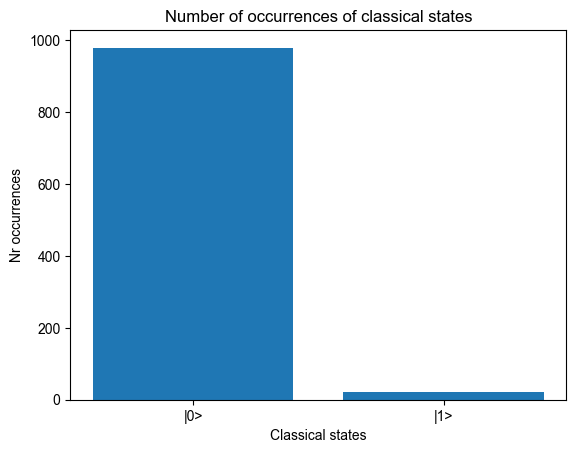

In [16]:
epsilon = 0.02
nu = 0.05
circuit = NoisyCircuit(1)
circuit.add_noisy_operation_readout(epsilon, nu, 0)
result = QuantumUtil.run_circuit(circuit, nr_runs=1000)
QuantumUtil.histogram_of_classical_states(result)

## Example noisy circuit of 4 qubits with read-out error
Below a noisy circuit is defined consisting of 4 qubits. A Hadamard operation and three CNOT operations are applied. A read-out error with $\epsilon = 0.2$ and $\nu = 0.05$ is applied to all qubits. The circuit is executed once and the final state is measured $10000$ times.

H...
*X..
.*X.
..*X


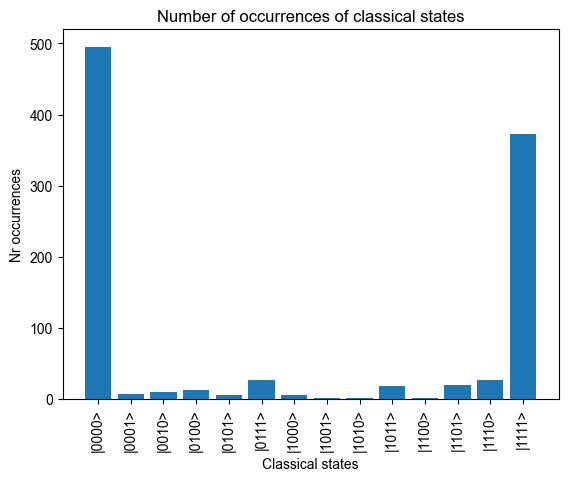

In [17]:
N = 4
epsilon = 0.02
nu = 0.05
circuit = NoisyCircuit(N)
circuit.hadamard(0)
for i in range(N-1):
    circuit.cnot(i,i+1)
for q in range(N):
    circuit.add_noisy_operation_readout(epsilon, nu, q)
circuit.print_gates()
result = QuantumUtil.measure_circuit(circuit, nr_measurements=1000)
QuantumUtil.histogram_of_classical_states(result)

## Example noisy circuit with 1 qubit
Below a noisy circuit is defined with 1 qubit. The Pauli X operation is applied 100 times and after each Pauli X operation, a rotation of 3 degrees about the x-axis is applied. 
In addition, a noisy state preparation with $p = 0.08$ is applied as well as a read-out error with $\epsilon = 0.2$ and $\nu = 0.05$. After every unitary operation, an operation to simulate incoherent noise is applied with parameters $p_x = 0.007$, $p_y = 0.008$, and $p_z = 0.009$.

In [18]:
n = 100 # Number of gate operations
circuit = NoisyCircuit(1)
for i in range(n):
    circuit.pauli_x(0)
    circuit.add_noisy_operation_coherent_x(3, 0)
circuit.add_noisy_operation_state_prep(0.08, 0)
circuit.add_noisy_operation_incoherent(0.007, 0.008, 0.009, 0)
circuit.add_noisy_operation_readout(0.02, 0.05, 0)

The final state of the circuit is measured 1000 times. A histogram of resulting states is shown followed by plots of $x$, $y$, and $z$ values for the qubit during execution of the circuit. Intermediate states and probabilities can be inspected by uncommenting the two last lines of code.

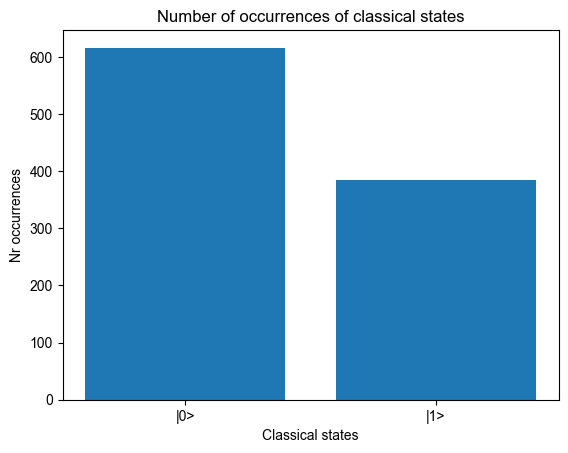

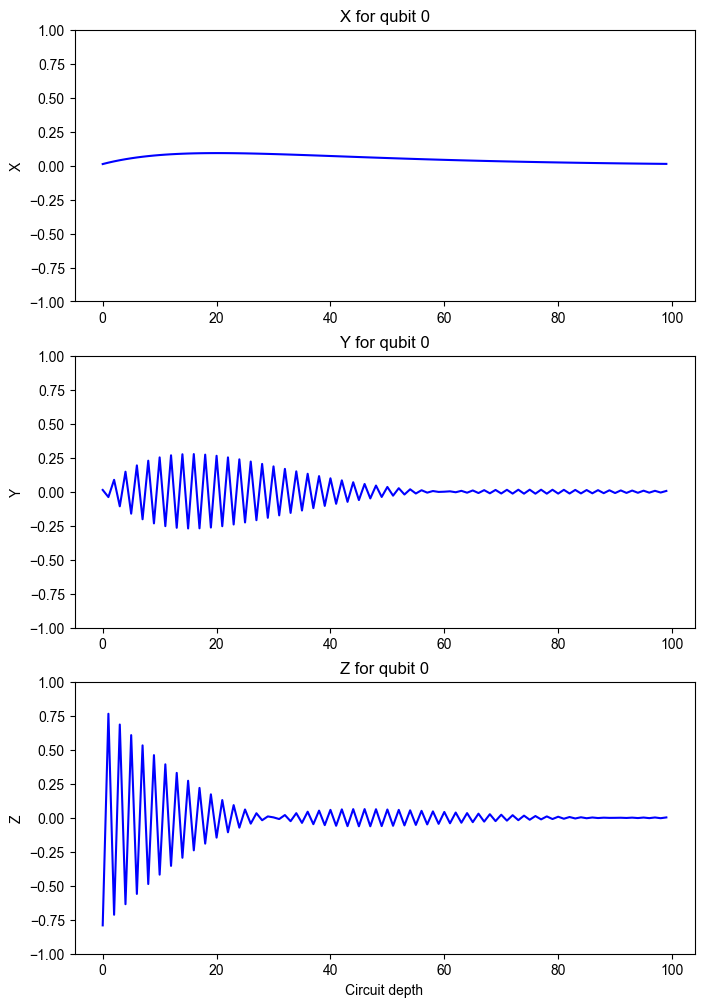

In [19]:
result = QuantumUtil.measure_circuit(circuit, nr_measurements=1000)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.plot_intermediate_states_per_qubit(circuit)
#QuantumUtil.show_all_probabilities(circuit)
#QuantumUtil.show_all_intermediate_states(circuit)

## Example noisy circuit with 2 qubits
Below a noisy circuit is defined with 2 qubits. The Pauli X operation is applied to the first qubit and after each Pauli X operation, a rotation of 3 degrees about the x-axis is applied.
In a similar fashion, the Pauli Y operation is applied to the second qubit an after each Pauli Y operation, a rotation of 4 degrees about the y-axis is applied. These operations are repeated 100 times.

State preparation errors, read-out errors and incoherent noise is applied to both qubits.

As before, the histogram and plots of $x$, $y$, and $z$ during execution are shown.

Intermediate states and probabilities can be inspected by uncommenting the two last lines of code.

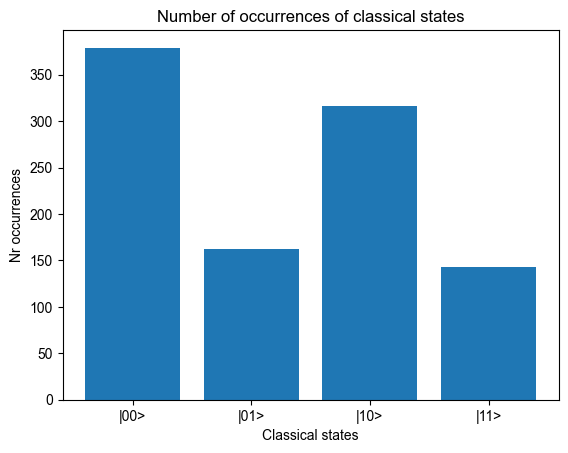

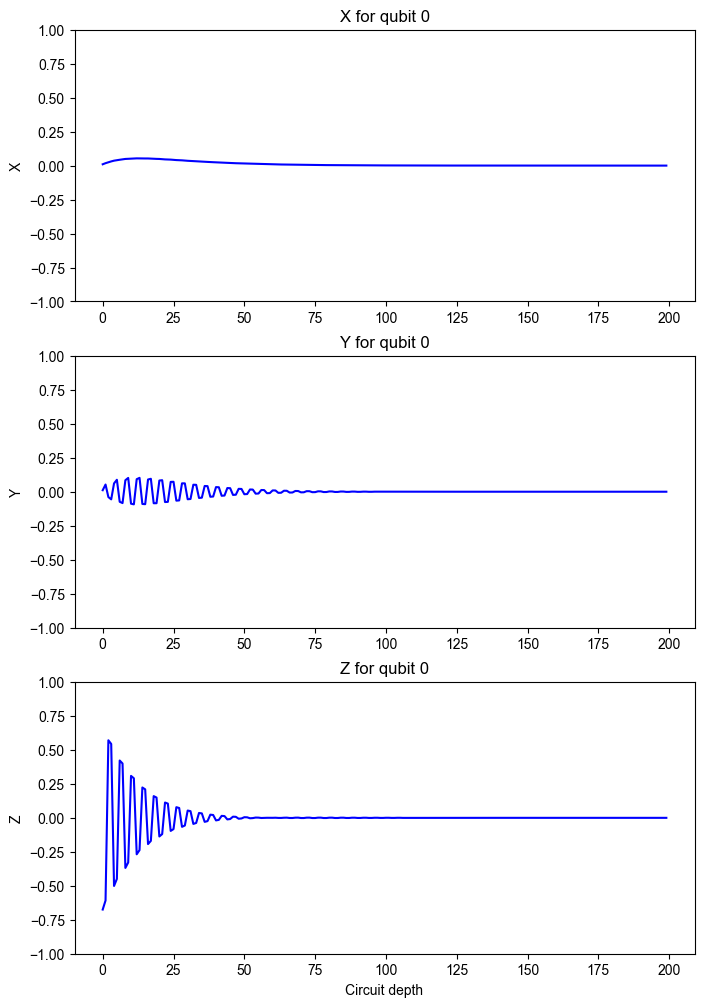

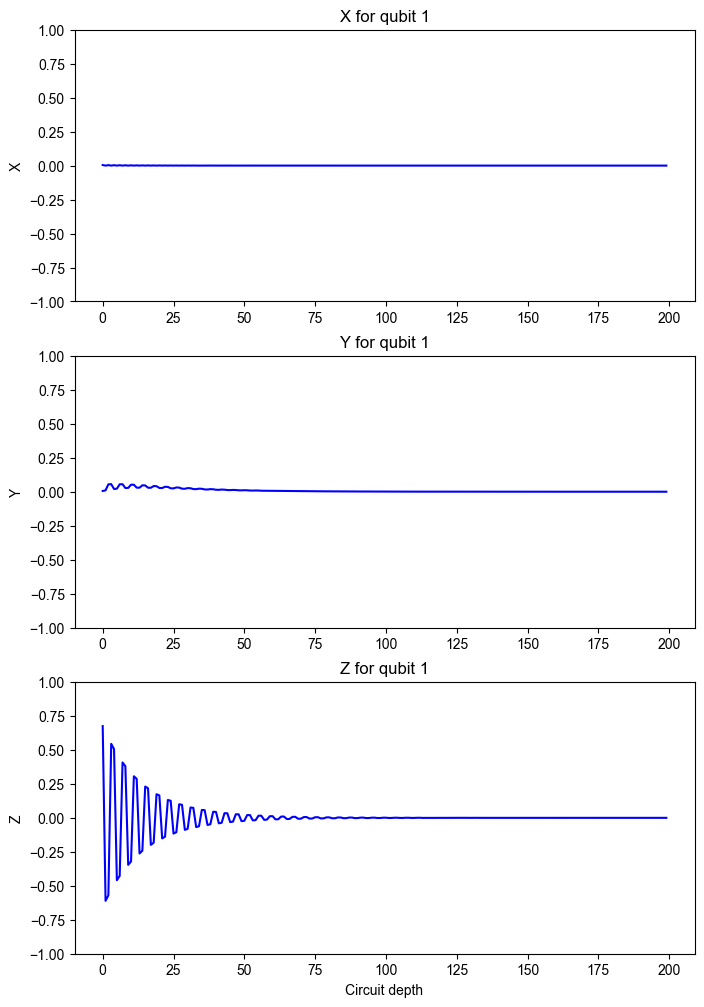

In [20]:
N = 2 # Number of qubits in circuit
n = 100 # Number of gate operations
circuit = NoisyCircuit(N)
for i in range(n):
    circuit.pauli_x(0)
    circuit.add_noisy_operation_coherent_x(3, 0)
    circuit.pauli_y(1)
    circuit.add_noisy_operation_coherent_x(4, 1)
circuit.add_noisy_operation_state_prep(0.08, 0)
circuit.add_noisy_operation_state_prep(0.07, 1)
circuit.add_noisy_operation_incoherent(0.007, 0.008, 0.009, 0)
circuit.add_noisy_operation_incoherent(0.003, 0.004, 0.005, 1)
circuit.add_noisy_operation_readout(0.02, 0.05, 0)
circuit.add_noisy_operation_readout(0.04, 0.03, 0)

result = QuantumUtil.measure_circuit(circuit, nr_measurements=1000)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.plot_intermediate_states_per_qubit(circuit)
#QuantumUtil.show_all_probabilities(circuit)
#QuantumUtil.show_all_intermediate_states(circuit)

## Another example with 2 qubits and noise
Below another noisy circuit with 2 qubits is defined. The Pauli X operation is applied to the first qubit and after each Pauli X operation, a CNOT operation with the first qubit as control and the second qubit as target is applied. After each Pauli X operation on the first qubit, a rotation of 3 degrees about the x-axis is applied.

As before, the histogram and plots of $x$, $y$, and $z$ during execution are shown. In addition, all probabilities and intermediate states are shown.

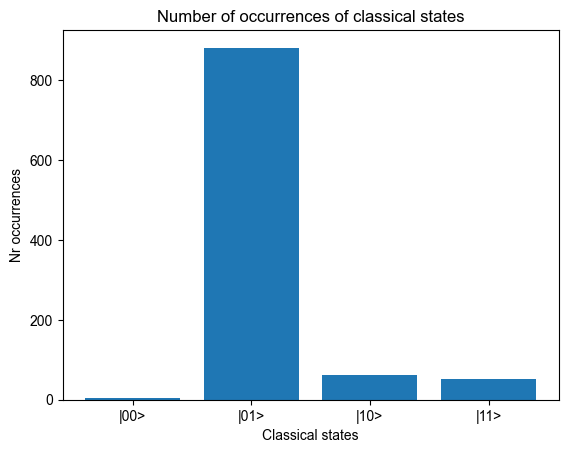

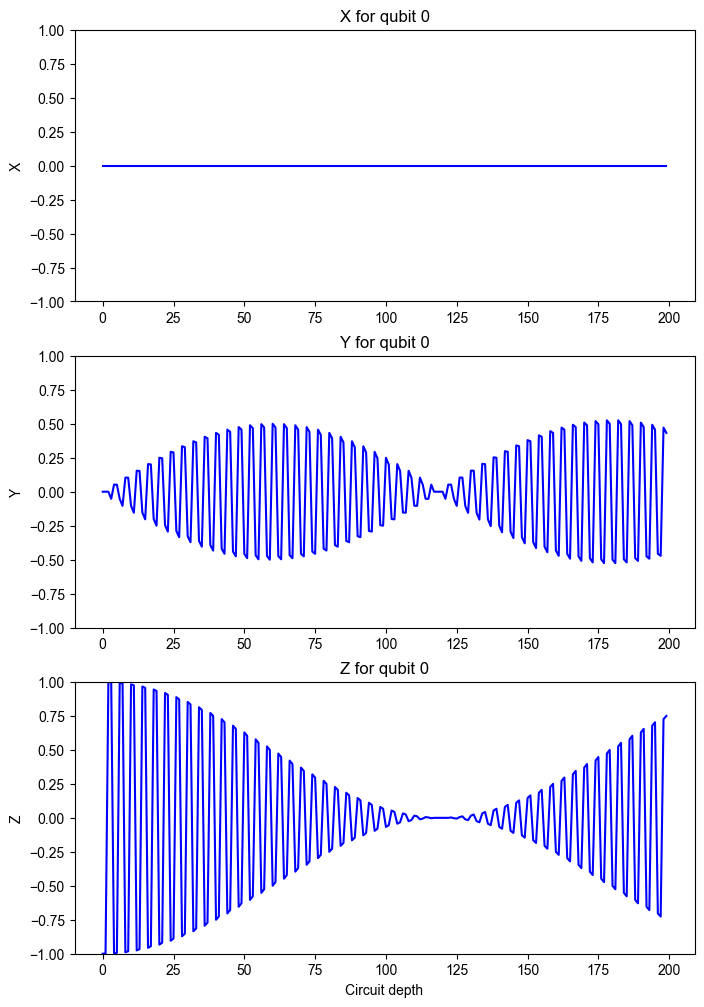

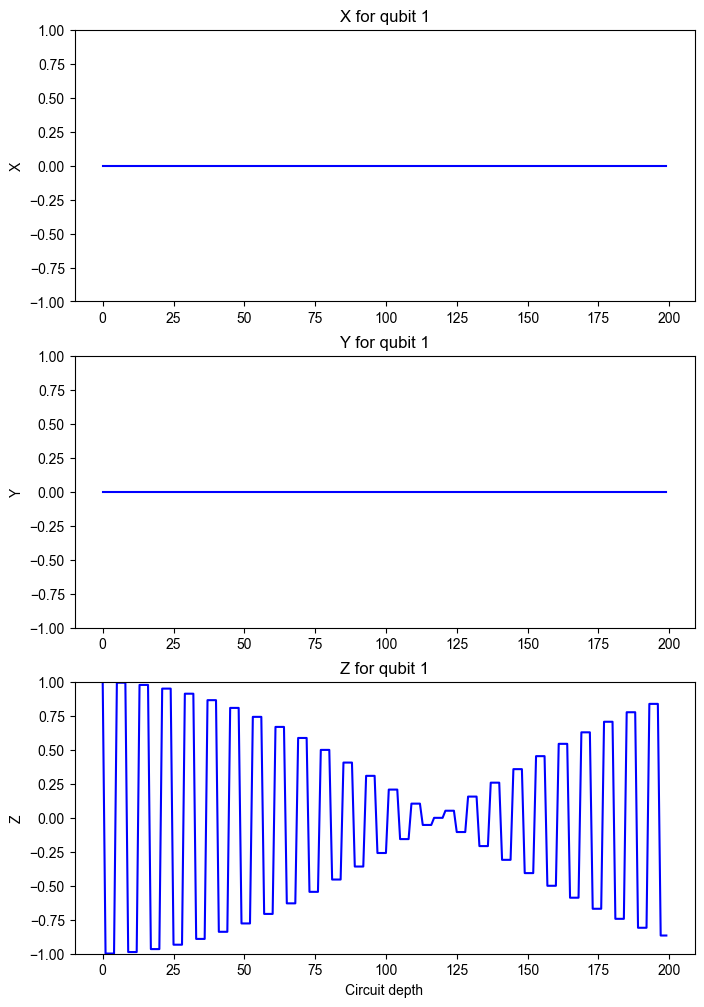

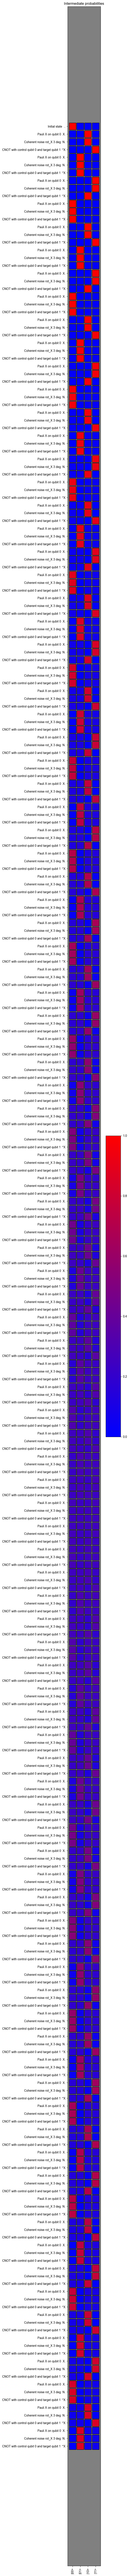

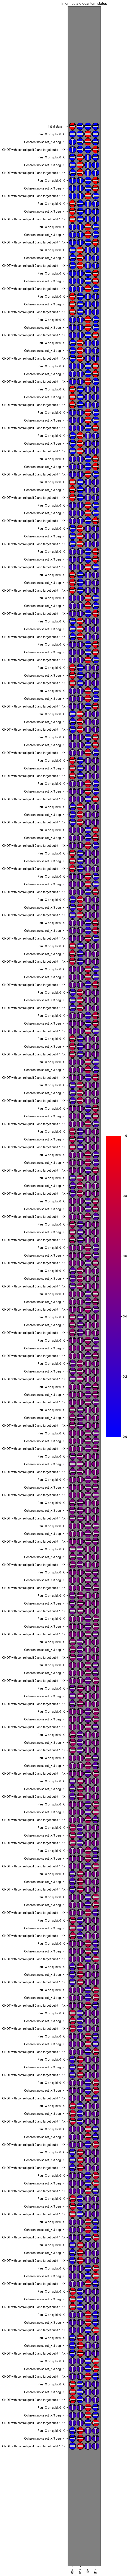

In [21]:
N = 2 # Number of qubits in circuit
n = 100 # Number of gate operations
circuit = NoisyCircuit(N)
for i in range(n):
    circuit.pauli_x(0)
    circuit.add_noisy_operation_coherent_x(3, 0)
    circuit.cnot(0,1)

result = QuantumUtil.measure_circuit(circuit, nr_measurements=1000)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.plot_intermediate_states_per_qubit(circuit)
QuantumUtil.show_all_probabilities(circuit)
QuantumUtil.show_all_intermediate_states(circuit)